In [1]:
import scipy.io
import scipy.ndimage
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from timeit import default_timer
import torch
import pickle
from functools import partial

from Solver import *


import sys
sys.path.append('../Utility')
import NeuralNet
import KalmanInversion 
from Numerics import interpolate_f2c, gradient_first_f2c
# import imp
# imp.reload(KalmanInversion )
# imp.reload(NeuralNet )





# Generate Training data

100000 max q 0.15420940171016215
200000 max q 0.16105500139707368
300000 max q 0.1612135690621972
400000 max q 0.16121705302977674
500000 max q 0.1612171295332711
Last step increment is :  5.244638612664234e-07  last step is :  1.0869268110500834
100000 max q 0.22587322936901522
200000 max q 0.22798575440830837
300000 max q 0.22799540970998744
400000 max q 0.22799545330412824
500000 max q 0.22799545350094425
Last step increment is :  1.349271491532571e-09  last step is :  1.537146653703915
100000 max q 0.2784558907343084
200000 max q 0.27923521393101597
300000 max q 0.27923626097074616
400000 max q 0.27923626237508703
500000 max q 0.27923626237669746
Last step increment is :  1.10940588520717e-11  last step is :  1.8826124807061453
100000 max q 0.32211004034818674
200000 max q 0.3224341061004881
300000 max q 0.3224342624262979
400000 max q 0.3224342625014399
500000 max q 0.3224342625014399
Last step increment is :  0.0  last step is :  2.173853645031209
100000 max q 0.3603452553980225


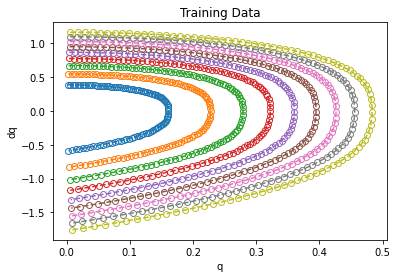

In [2]:
xx, f, q, q_c, dq_c = generate_data(plot_or_not = True)

# Training Loss : || d(D dq/dy)/dy + f(x)|| on the quadratic function

In [3]:
def loss_aug(s_param, params):
    xx, q = s_param.xx, s_param.q
    ind, outd, width = s_param.ind, s_param.outd, s_param.width
    activation, initializer, outputlayer = s_param.activation, s_param.initializer, s_param.outputlayer
    
    N_data, Nx = q.shape
    # does not include top and bottom nodes
    res = np.zeros((N_data, Nx - 2))
    
    net =  NeuralNet.create_net(ind, outd, layers, width, activation, initializer, outputlayer,  params)
    nn_model = partial(NeuralNet.nn_viscosity, net=net, mu_scale=mu_scale, non_negative=non_negative, filter_on=filter_on, filter_sigma=filter_sigma)
    
    for i in range(N_data):
        nummodel(nn_model, q[i, :], xx[i, :], res[i, :])
        
    return np.hstack((-np.reshape(res, -1), params))



## Start UKI

In [4]:
class PoissonParam:
    def __init__(self, xx, q, N_y, ind, outd, layers, width, activation, initializer, outputlayer):
        self.theta_names = ["hyperparameters"]
        self.xx = xx
        self.q  = q
        self.ind  = ind
        self.outd = outd
        self.width = width
        self.activation = activation
        self.initializer = initializer
        self.outputlayer = outputlayer
        
        
        N_theta = ind*width + (layers - 2)*width**2 + width*outd + (layers - 1)*width + outd
        self.N_theta = N_theta
        
        
        self.N_y = N_y + N_theta 

In [5]:
y = np.reshape(f[:, 1:Nx - 1], -1)
Sigma_eta = np.fabs(f[:, 1:Nx - 1])
for i in range(n_data):
    Sigma_eta[i, :] = np.mean(Sigma_eta[i, :])
Sigma_eta = np.diag(np.reshape((Sigma_eta*0.01)**2, -1))


N_y = len(y)

s_param = PoissonParam(xx, q, N_y, ind, outd, layers, width, activation, initializer, outputlayer)
N_theta = s_param.N_theta

theta0_mean_init = NeuralNet.FNN(ind, outd, layers, width, activation, initializer, outputlayer).get_params()
theta0_mean = np.zeros(N_theta)

theta0_cov = np.zeros((N_theta, N_theta))
np.fill_diagonal(theta0_cov, 10.0**2)  
theta0_cov_init = np.zeros((N_theta, N_theta))
np.fill_diagonal(theta0_cov_init, 1.0**2)  


y_aug = np.hstack((y, theta0_mean))
Sigma_eta_aug = block_diag(Sigma_eta, theta0_cov)
print(" N_theta = ", s_param.N_theta, " N_y = ", s_param.N_y)
print(" q = ", s_param.q.shape)


alpha_reg = 1.0
update_freq = 1
N_iter = 50
gamma = 1.0

save_folder = "indirect_NN_res"
uki_obj = KalmanInversion.UKI_Run(s_param, loss_aug, 
    theta0_mean, theta0_mean_init, 
    theta0_cov,  theta0_cov_init, 
    y_aug, Sigma_eta_aug,
    alpha_reg,
    gamma,
    update_freq, 
    N_iter,
    save_folder = save_folder)

 N_theta =  41  N_y =  923
 q =  (9, 100)
ukiobj.gamma :  1.0
optimization error at iter  0  =  1587543039.42386
data-misfit :  1587543021.270197 reg :  18.153663312560358
Frobenius norm of the covariance at iter  0  =  6.4031242374328485
ukiobj.gamma :  0.5
optimization error at iter  1  =  2265164649.983122
data-misfit :  2265164629.2093644 reg :  20.77375714188728
Frobenius norm of the covariance at iter  1  =  10.182737956539965
ukiobj.gamma :  0.5
optimization error at iter  2  =  7599025.140109966
data-misfit :  7599013.148675403 reg :  11.991434562691351
Frobenius norm of the covariance at iter  2  =  2.2961193667529756
ukiobj.gamma :  0.5
optimization error at iter  3  =  2064590.439109406
data-misfit :  2064578.0829411058 reg :  12.35616830005019
Frobenius norm of the covariance at iter  3  =  0.11369879039813173
ukiobj.gamma :  0.5
optimization error at iter  4  =  170909.9587783829
data-misfit :  170898.5301825892 reg :  11.428595793719968
Frobenius norm of the covariance at